# Exploratory Data Analysis of UK Online Retail Transactions
**Author:** Brian Monter  
**Date:** 2025-05-08 

**Overview:**  
In this project, you step into the shoes of an entry-level data analyst at an online retail company, working with one year of UK transactional data to uncover sales trends, customer behavior, and product performance.

**Objectives:**  
1. Clean and describe the data to answer key business questions  
2. Visualize sales patterns over time, by product, customer, and geography  
3. Provide data-driven recommendations to optimize store operations

## Table of Contents
1. [Introduction](#introduction)  
2. [Imports & Setup](#imports--setup)  
3. [Data Loading & Initial Inspection](#data-loading--initial-inspection)  
4. [Data Cleaning](#data-cleaning)  
5. [Feature Engineering](#feature-engineering)  
6. [Exploratory Analyses](#exploratory-analyses)  
   1. [Monthly Revenue Trend](#monthly-revenue-trend)  
   2. [Top Products](#top-products)  
   3. [Top Customers](#top-customers)  
   4. [Geographic Breakdown](#geographic-breakdown)  
7. [Outlier Analysis](#outlier-analysis)  
8. [Correlation Analysis](#correlation-analysis)  
9. [Summary of Findings & Recommendations](#summary-of-findings--recommendations)  

## 2. Imports & Setup

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns



# Optional styling
sns.set(style="whitegrid")
%matplotlib inline

## 3. Data Loading & Initial Inspection

In [19]:
# Data Load
file_path = 'Online Retail.xlsx'  
df = pd.read_excel(file_path)

# Initial Inspection
print(df.shape)
display(df.head())
df.info()

(541909, 8)


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


## 4. Data Cleaning

In [21]:
# 4.1 Drop cancelled orders (InvoiceNo starting with 'C')
df_clean = df[~df['InvoiceNo'].astype(str).str.startswith('C')].copy()

# 4.2 Remove rows with non‐positive quantities or prices
df_clean = df_clean[(df_clean['Quantity'] > 0) & (df_clean['UnitPrice'] > 0)]

# 4.3 Drop transactions missing CustomerID
df_clean = df_clean.dropna(subset=['CustomerID'])

# 4.4 Convert InvoiceDate to datetime and extract date parts
df_clean['InvoiceDate'] = pd.to_datetime(df_clean['InvoiceDate'])
df_clean['Year']       = df_clean['InvoiceDate'].dt.year
df_clean['Month']      = df_clean['InvoiceDate'].dt.month
df_clean['DayOfWeek']  = df_clean['InvoiceDate'].dt.day_name()

# 4.5 Quick sanity checks
print("Original shape:", df.shape)
print("Cleaned shape:", df_clean.shape)
display(df_clean.info())

Original shape: (541909, 8)
Cleaned shape: (397884, 11)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 397884 entries, 0 to 541908
Data columns (total 11 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    397884 non-null  object        
 1   StockCode    397884 non-null  object        
 2   Description  397884 non-null  object        
 3   Quantity     397884 non-null  int64         
 4   InvoiceDate  397884 non-null  datetime64[ns]
 5   UnitPrice    397884 non-null  float64       
 6   CustomerID   397884 non-null  float64       
 7   Country      397884 non-null  object        
 8   Year         397884 non-null  int64         
 9   Month        397884 non-null  int64         
 10  DayOfWeek    397884 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(3), object(5)
memory usage: 36.4+ MB


None

## 5. Feature Engineering

In [22]:
# 5.1 Compute Revenue per line
df_clean['Revenue'] = df_clean['Quantity'] * df_clean['UnitPrice']

# 5.2 Create a month‐period column for easy grouping
df_clean['InvoiceMonth'] = df_clean['InvoiceDate'].dt.to_period('M')

# 5.3 Compute Order-level totals 
order_totals = (
    df_clean
    .groupby('InvoiceNo')['Revenue']
    .sum()
    .rename('OrderValue')
    .reset_index()
)
# Merge back:
df_clean = df_clean.merge(order_totals, on='InvoiceNo')

# 5.4 Quick check
display(df_clean[['InvoiceNo','InvoiceDate','Quantity','UnitPrice','Revenue','InvoiceMonth','OrderValue']].head())
df_clean[['Revenue','OrderValue']].describe()


,InvoiceNo,InvoiceDate,Quantity,UnitPrice,Revenue,InvoiceMonth,OrderValue
0,536365,2010-12-01 08:26:00,6,2.55,15.30,2010-12,139.12
1,536365,2010-12-01 08:26:00,6,3.39,20.34,2010-12,139.12
2,536365,2010-12-01 08:26:00,8,2.75,22.00,2010-12,139.12
3,536365,2010-12-01 08:26:00,6,3.39,20.34,2010-12,139.12
4,536365,2010-12-01 08:26:00,6,3.39,20.34,2010-12,139.12


,Revenue,OrderValue
count,397884.000000,397884.000000
mean,22.397000,745.948994
std,309.071041,1475.142241
min,0.001000,0.380000
25%,4.680000,251.260000
50%,11.800000,394.280000
75%,19.800000,690.340000
max,168469.600000,168469.600000


## 6. Exploratory Analysis

### 6.1 Monthly Revenue Trend

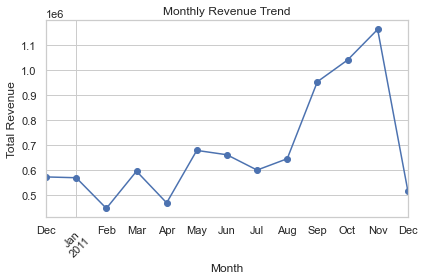

,Month,TotalRevenue
0,2010-12,572713.890
1,2011-01,569445.040
2,2011-02,447137.350
3,2011-03,595500.760
4,2011-04,469200.361
5,2011-05,678594.560
6,2011-06,661213.690
7,2011-07,600091.011
8,2011-08,645343.900
9,2011-09,952838.382


In [23]:

# Aggregate monthly revenue
monthly_revenue = df_clean.groupby('InvoiceMonth')['Revenue'].sum().sort_index()

# Plot the monthly revenue trend
plt.figure()
monthly_revenue.plot(marker='o')
plt.title('Monthly Revenue Trend')
plt.xlabel('Month')
plt.ylabel('Total Revenue')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# View the numbers in a DataFrame
monthly_revenue_df = monthly_revenue.reset_index().rename(columns={
    'InvoiceMonth': 'Month',
    'Revenue': 'TotalRevenue'
})
monthly_revenue_df.head(12)

### 6.2 Top 10 Products by Total Revenue

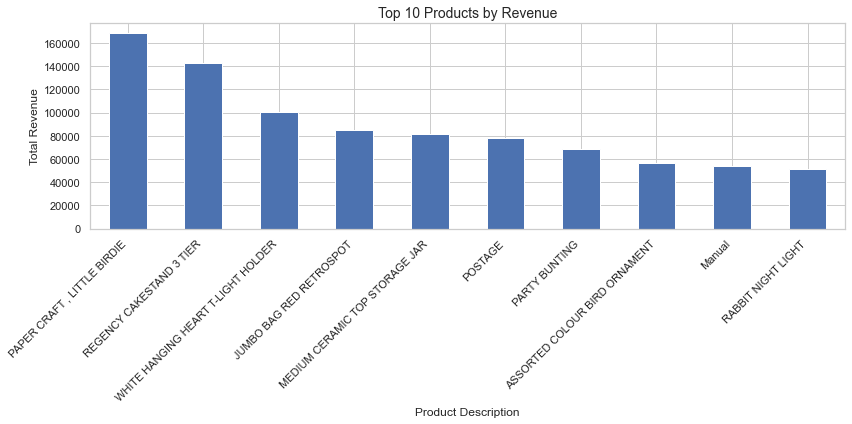

,Description,TotalRevenue
0,"PAPER CRAFT , LITTLE BIRDIE",168469.60
1,REGENCY CAKESTAND 3 TIER,142592.95
2,WHITE HANGING HEART T-LIGHT HOLDER,100448.15
3,JUMBO BAG RED RETROSPOT,85220.78
4,MEDIUM CERAMIC TOP STORAGE JAR,81416.73
5,POSTAGE,77803.96
6,PARTY BUNTING,68844.33
7,ASSORTED COLOUR BIRD ORNAMENT,56580.34
8,Manual,53779.93
9,RABBIT NIGHT LIGHT,51346.20


In [7]:
# Top 10 products by total revenue
top_products_rev = (
    df_clean
    .groupby('Description')['Revenue']
    .sum()
    .nlargest(10)
)

# Plot
plt.figure(figsize=(12,6))
top_products_rev.plot(kind='bar')
plt.xlabel('Product Description', fontsize=12)
plt.ylabel('Total Revenue', fontsize=12)
plt.title('Top 10 Products by Revenue', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# View the numbers
top_products_rev.reset_index(name='TotalRevenue')


### 6.3 Top 10 Customers by Total Spend

,CustomerID,TotalRevenue
0,14646.0,280206.02
1,18102.0,259657.30
2,17450.0,194550.79
3,16446.0,168472.50
4,14911.0,143825.06
5,12415.0,124914.53
6,14156.0,117379.63
7,17511.0,91062.38
8,16029.0,81024.84
9,12346.0,77183.60


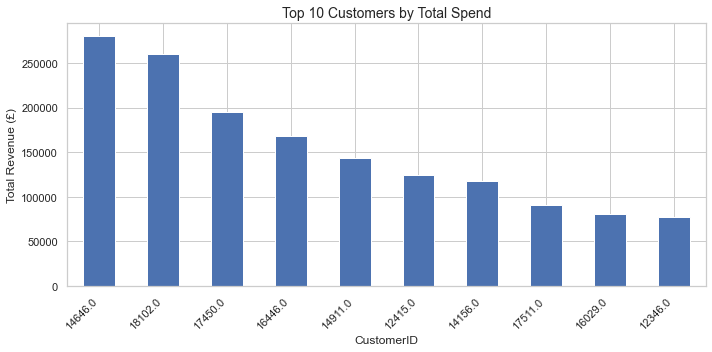

In [8]:
# Top 10 customers by total spend
top_customers = (
    df_clean
    .groupby('CustomerID')['Revenue']
    .sum()
    .nlargest(10)
)

# Convert to DataFrame for display
top_customers_df = top_customers.reset_index().rename(columns={
    'Revenue': 'TotalRevenue'
})

# Display the table
display(top_customers_df)

# Bar chart of top customers
plt.figure(figsize=(10,5))
top_customers.plot(kind='bar')
plt.xlabel('CustomerID', fontsize=12)
plt.ylabel('Total Revenue (£)', fontsize=12)
plt.title('Top 10 Customers by Total Spend', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


### 6.4 Geographic Breakdown

,Country,TotalRevenue
0,United Kingdom,7308391.554
1,Netherlands,285446.340
2,EIRE,265545.900
3,Germany,228867.140
4,France,209024.050
5,Australia,138521.310
6,Spain,61577.110
7,Switzerland,56443.950
8,Belgium,41196.340
9,Sweden,38378.330


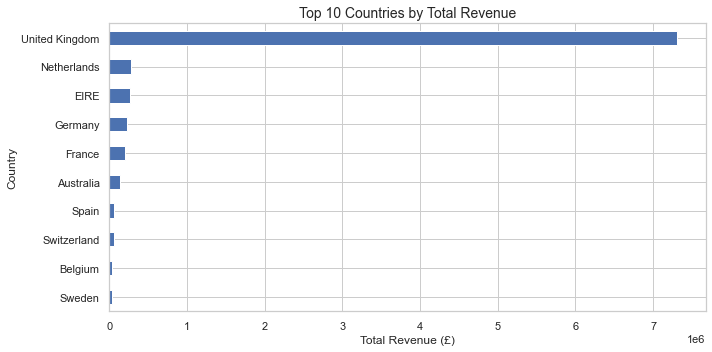

In [10]:
# 1. Prepare the data
country_revenue = df_clean.groupby('Country')['Revenue'].sum().sort_values(ascending=False)
top_countries = country_revenue.head(10)

# 2. Create a DataFrame and display it
top_countries_df = top_countries.reset_index(name='TotalRevenue')
display(top_countries_df)

# 3. Plot the horizontal bar chart
plt.figure(figsize=(10,5))
top_countries.plot(kind='barh')
plt.xlabel('Total Revenue (£)', fontsize=12)
plt.ylabel('Country', fontsize=12)
plt.title('Top 10 Countries by Total Revenue', fontsize=14)
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


## 7. Outlier Analysis

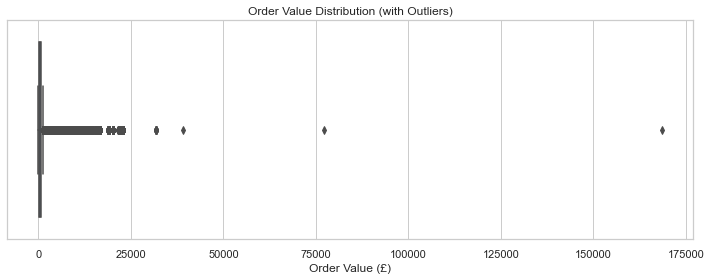

count    397884.000000
mean        745.948994
std        1475.142241
min           0.380000
25%         251.260000
50%         394.280000
75%         690.340000
max      168469.600000
Name: OrderValue, dtype: float64

Key Percentiles:
0.01      68.00
0.05     120.33
0.95    2221.02
0.99    8107.72
Name: OrderValue, dtype: float64


In [11]:
# Boxplot of OrderValue to spot outliers
plt.figure(figsize=(10,4))
sns.boxplot(x=df_clean['OrderValue'])
plt.title('Order Value Distribution (with Outliers)')
plt.xlabel('Order Value (£)')
plt.tight_layout()
plt.show()

# Summary statistics and extreme percentiles
print(df_clean['OrderValue'].describe())
print("\nKey Percentiles:")
print(df_clean['OrderValue'].quantile([0.01, 0.05, 0.95, 0.99]))


## 8. Correlation Analysis

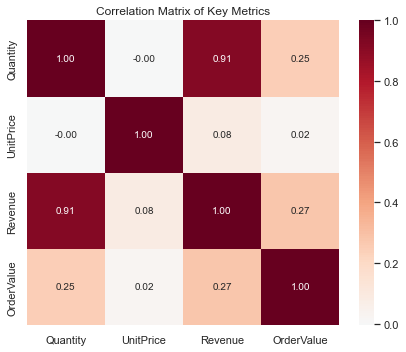

In [14]:
#Correlation Heat-Map


# Select the numeric columns of interest
num_cols = ['Quantity', 'UnitPrice', 'Revenue', 'OrderValue']

# Compute correlation matrix
corr_matrix = df_clean[num_cols].corr()

# Plot the heat-map
plt.figure(figsize=(6,5))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='RdBu_r', center=0)
plt.title('Correlation Matrix of Key Metrics')
plt.tight_layout()
plt.show()



## 9. Summary & Findings

## 9. Summary of Findings & Recommendations

### Summary of Findings
- **Seasonal Revenue Patterns**
  - February & April dips (≈£447 K/£469 K); Q4 surge peaking at ~£1.16 M.
  - Spring rebound (May–June) and modest summer plateau.

- **Top Products**
  - By revenue: “PAPER CRAFT , LITTLE BIRDIE” (£168 K), “REGENCY CAKESTAND 3 TIER” (£143 K), etc.
  - “POSTAGE” and “Manual” skew merchandise figures—treat separately.

- **Top Customers**
  - Top customer spent ~£280 K; top 10 account for ~£1.54 M (≈18 % of total).

- **Geographic Breakdown**
  - UK drives ~£7.38 M of £8.4 M.
  - Top export markets: Netherlands, EIRE, Germany, France, Australia.

- **Outliers**
  - Typical order value: median ~£394, 99th percentile ~£8.1 K; max ~£168 K.

- **Correlations**
  - Quantity vs. Revenue: 0.91 (very strong).
  - Revenue vs. OrderValue: 0.27 (moderate).
  - UnitPrice vs. others: ~0 (weak).

### Recommendations
1. **Smooth Seasonality:**  
   - Run off-peak promotions in Feb/Apr; summer product launches in May/Jun.
2. **Stock & Merchandising:**  
   - Prioritize top‐revenue SKUs; bundle best-sellers.
3. **Customer Strategy:**  
   - VIP program for top spenders; broaden acquisition to reduce concentration risk.
4. **Export Focus:**  
   - Target Netherlands, EIRE, Germany, France, Australia; tailor offers by average order size.
5. **Data Quality:**  
   - Cap/cull outliers above £8 K when reporting; investigate “Manual”/“POSTAGE” entries.
6. **Pricing & Promotions:**  
   - Use volume discounts to drive higher quantities; test tiered pricing for frequent buyers.
